In [2]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
# import pytorch_wavelets as pw
from torch.nn.modules.utils import _pair, _quadruple
import pywt

In [3]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])
#from online: the mean of MNIST is 0.1307, the std 0.3081
# https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457

trainset = torchvision.datasets.MNIST(root= '../data', train=True,
                                        download=True, transform=transform)
#keep batches in 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=True, num_workers=2)

## Attempted Wavelets:

Haar: Fully Connected 1(9216, 128)
Daubechies 1: Fully Connected 1 (9216,128)
Daubechies 2: Fully Connected 2(7744, 128)

In [28]:
import torch
import torch.nn as nn
import numpy as np

def get_wav(in_channels,  pool=True):
    """wavelet decomposition using conv2d"""
    
    w = pywt.Wavelet('coif1')
    
    dec_hi = torch.Tensor(w.dec_hi[::-1]) 
    dec_lo = torch.Tensor(w.dec_lo[::-1])
    rec_hi = torch.Tensor(w.rec_hi)
    rec_lo = torch.Tensor(w.rec_lo)
    
    filter_LL = dec_lo.unsqueeze(0)*dec_lo.unsqueeze(1)
    filter_LH = dec_lo.unsqueeze(0)*dec_hi.unsqueeze(1)
    filter_HL = dec_hi.unsqueeze(0)*dec_lo.unsqueeze(1)
    filter_HH = dec_hi.unsqueeze(0)*dec_hi.unsqueeze(1)
 
    if pool:
        model = nn.Conv2d
    else:
        model = nn.ConvTranspose2d

    LL = model(in_channels, in_channels,
             kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    LH = model(in_channels, in_channels,
             kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    HL = model(in_channels, in_channels,kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    HH = model(in_channels, in_channels,kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)

    LL.weight.requires_grad = False
    LH.weight.requires_grad = False
    HL.weight.requires_grad = False
    HH.weight.requires_grad = False

    LL.weight.data = filter_LL.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    LH.weight.data = filter_LH.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    HL.weight.data = filter_HL.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    HH.weight.data = filter_HH.float().unsqueeze(0).expand(in_channels, -1, -1, -1)

    return LL, LH, HL, HH

class WavePool(nn.Module):
    def __init__(self,in_channels):
        super(WavePool,self).__init__()
        self.LL,self.LH,self.HL,self.HH = get_wav(in_channels)

    def forward(self,x):
        return self.LL(x)

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(6400, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = WavePool(64)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [32]:
net = Net()
train_loss = []
run_loss = []
test_loss = []
test_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(10):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in testloader:
            output = net(data)
            testing_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    
    test_loss.append(testing_loss / len(testloader.dataset))
    test_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Loss: %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, testing_loss / len(testloader.dataset), correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.858
[1,  2000] running loss: 0.199
[1,  3000] running loss: 0.094
[1,  4000] running loss: 0.063
[1,  5000] running loss: 0.047
[1,  6000] running loss: 0.032
[1,  7000] running loss: 0.024
[1,  8000] running loss: 0.018
[1,  9000] running loss: 0.017
[1, 10000] running loss: 0.016
[1, 11000] running loss: 0.014
[1, 12000] running loss: 0.011
[1, 13000] running loss: 0.009
[1, 14000] running loss: 0.009
[1, 15000] running loss: 0.008
Epoch 1, Training Loss:  0.233, Testing Loss: 0.114, Testing Accuracy: 0.966
[2,  1000] running loss: 0.120
[2,  2000] running loss: 0.053
[2,  3000] running loss: 0.042
[2,  4000] running loss: 0.029
[2,  5000] running loss: 0.018
[2,  6000] running loss: 0.017
[2,  7000] running loss: 0.015
[2,  8000] running loss: 0.012
[2,  9000] running loss: 0.011
[2, 10000] running loss: 0.008
[2, 11000] running loss: 0.009
[2, 12000] running loss: 0.006
[2, 13000] running loss: 0.008
[2, 14000] running loss: 0.006
[2, 15000] running loss:

Text(0, 0.5, 'Error')

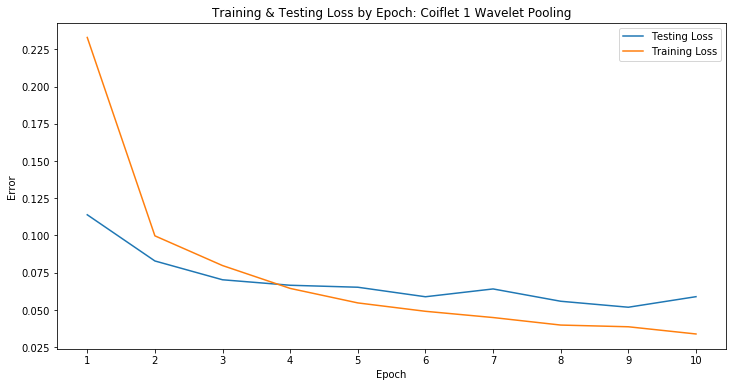

In [36]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(1,11, step=1), test_loss, label = 'Testing Loss')
plt.plot(np.arange(1, 11, step=1), train_loss, label = 'Training Loss')
plt.title('Training & Testing Loss by Epoch: Coiflet 1 Wavelet Pooling')
plt.xticks(np.arange(1,11, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error')

In [33]:
train_loss

[0.23292358226157336,
 0.09975541489853627,
 0.07980467772406803,
 0.06446848423736137,
 0.05473314325341836,
 0.049103285188131396,
 0.044914317613794275,
 0.03986355746098464,
 0.03871431477167167,
 0.033880849774967636]

In [34]:
test_loss

[0.1138985889738972,
 0.08289015053904954,
 0.07026553207495086,
 0.06658386168813377,
 0.06525674848222789,
 0.05886800639261856,
 0.06411255370162855,
 0.05584366903266115,
 0.05183299870404483,
 0.0589155394139872]

In [35]:
run_loss

[0.8582364573515952,
 0.19905514483095613,
 0.09423051193143085,
 0.06255899411484177,
 0.04699365791357123,
 0.03175221905371359,
 0.024281240664043715,
 0.018240639954725708,
 0.016935192846612355,
 0.015978291093027293,
 0.013677417449185585,
 0.011421256199249608,
 0.009386610368887258,
 0.008763579365211435,
 0.007918780512657899,
 0.12037498936799071,
 0.05261716058555886,
 0.0423823826412513,
 0.0289956926647684,
 0.017834844477151182,
 0.016932556045302496,
 0.015074822254392963,
 0.01217150559175996,
 0.011273674746743192,
 0.007771195924985327,
 0.00925260836837285,
 0.006490919885024359,
 0.007700777238560418,
 0.0061657182747587155,
 0.005910114172857588,
 0.0900792873722213,
 0.04093543670310601,
 0.024691316566752497,
 0.01634119638124985,
 0.016391153251748825,
 0.013659292322694805,
 0.011563008398447063,
 0.010198497019687893,
 0.008958249554387015,
 0.00813247301909946,
 0.007233077614640866,
 0.007131758147991766,
 0.005900457306762698,
 0.00511123795631664,
 0.00559